# Empirical Cross Covariance

Note that the analysis below assumes realizations are independent across time. This is a bad assumption, but should still provide a reasonable approximation.

- investigate space time data types in R
- check that variogramST can do covariogram (maybe with simple example)
- save out detrended and standardized data as netcdf

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

import krige_tools
from stat_tools import apply_detrend

In [4]:
# collect gridded dataset, standardize, and establish a common domain
df_grid = (
    pd.DataFrame(krige_tools.land_grid(res=5))
    .rename(columns={0:"lat", 1:"lon"})
    .assign(land=lambda x:1)
    .set_index(["lon", "lat"])
)

def detrend_standardize_da(da):
    da, _ = apply_detrend(da)
    return (da - da.mean(dim="time")) / da.std(dim="time")

with xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly.nc") as ds:
    ds = ds[["sif", "xco2"]]
    ds["sif"] = detrend_standardize_da(ds.sif)
    ds["xco2"] = detrend_standardize_da(ds.xco2)
    # residuals
    ds["sif_res"] = ds.sif - ds.sif.mean(dim="time")
    ds["xco2_res"] = ds.xco2 - ds.xco2.mean(dim="time")

df = ds.to_dataframe().join(df_grid).dropna(subset=["land"]).reset_index()
# df["lat_lon"] = df[["lat", "lon"]].apply(tuple, axis=1)
df

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


,lat,lon,time,sif,xco2,sif_res,xco2_res,land
0,-87.5,-177.5,2014-09-01,NaN,NaN,NaN,NaN,1.0
1,-87.5,-177.5,2014-10-01,NaN,NaN,NaN,NaN,1.0
2,-87.5,-177.5,2014-11-01,0.569884,NaN,0.569884,NaN,1.0
3,-87.5,-177.5,2014-12-01,-1.883614,NaN,-1.883614,NaN,1.0
4,-87.5,-177.5,2015-01-01,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
92770,82.5,97.5,2020-07-01,NaN,NaN,NaN,NaN,1.0
92771,82.5,97.5,2020-08-01,0.401270,NaN,0.401270,NaN,1.0
92772,82.5,97.5,2020-09-01,NaN,NaN,NaN,NaN,1.0
92773,82.5,97.5,2020-10-01,NaN,NaN,NaN,NaN,1.0


In [5]:
# NOTE: shared domain, there will be many missing values
spatial_domain = df_grid.reset_index()[["lat", "lon"]].values
temporal_domain = ds.time.values

In [6]:
D_s = krige_tools.distance_matrix(spatial_domain, spatial_domain, fast_dist=True)
D_t = krige_tools.distance_matrix_time(temporal_domain, temporal_domain)

In [7]:
pairs_s = krige_tools.get_dist_pairs(D_s, 500, tol=100)
pairs_t = krige_tools.get_dist_pairs(D_t, 2)

In [8]:
time_xco2 = temporal_domain[pairs_t[:,0]]
lat_xco2 = spatial_domain[pairs_s[:,0]][:, 0]
lon_xco2 = spatial_domain[pairs_s[:,0]][:, 1]

time_sif = temporal_domain[pairs_t[:,1]]
lat_sif = spatial_domain[pairs_s[:,1]][:, 0]
lon_sif = spatial_domain[pairs_s[:,1]][:, 1]

In [ ]:
for s in pairs_s:
    for t in pairs_t:
        print (s,t)

In [9]:
%%time 

positioned_xco2_res = ds.xco2_res.sel(time=time_sif, lat=lat_sif, lon=lon_sif).values
positioned_sif_res = ds.sif_res.sel(time=time_sif, lat=lat_sif, lon=lon_sif).values

CPU times: user 4min 51s, sys: 2min 59s, total: 7min 50s
Wall time: 7min 55s


In [10]:
np.nanmean(positioned_xco2_res * positioned_sif_res)

-0.32947138293446404

## Empirical Covariance matrix

In [4]:
df_sif = df.pivot(index="lat_lon", columns="time", values="sif")
df_xco2 = df.pivot(index="lat_lon", columns="time", values="xco2")

In [5]:
def outer_product(x1, x2):
    return np.outer(x1 - np.nanmean(x1), x2 - np.nanmean(x2))

def empirical_cross_cov(X1, X2, offset=0):
    # Cross covariance (lag=offset) of two spatio-temporal matrices with locations in rows and time along columns
    # Cressie and Wikle, eq (5.4)
    assert X1.shape[1] == X2.shape[1]
    return np.nanmean(np.stack([outer_product(X1[:, i+offset], X2[:, i]) for i in range(X1.shape[1] - offset)], axis=2), axis=2)

xco2_cov = empirical_cross_cov(df_xco2.values, df_xco2.values)
sif_cov = empirical_cross_cov(df_sif.values, df_sif.values)
xcov = empirical_cross_cov(df_xco2.values, df_sif.values, offset=2)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [6]:
def get_diag_std(C0):
    return np.diag(np.float_power(np.diag(C0), -0.5))

xco2_diag = get_diag_std(xco2_cov)
sif_diag = get_diag_std(sif_cov)

In [7]:
xcorr = np.matmul(xco2_diag, np.matmul(xcov, sif_diag))

In [32]:
# get the distance matrix
grid = np.array(list(df.groupby(["lat", "lon"]).groups.keys()))
dist_mat = krige_tools.distance_matrix(grid, grid, fast_dist=True)

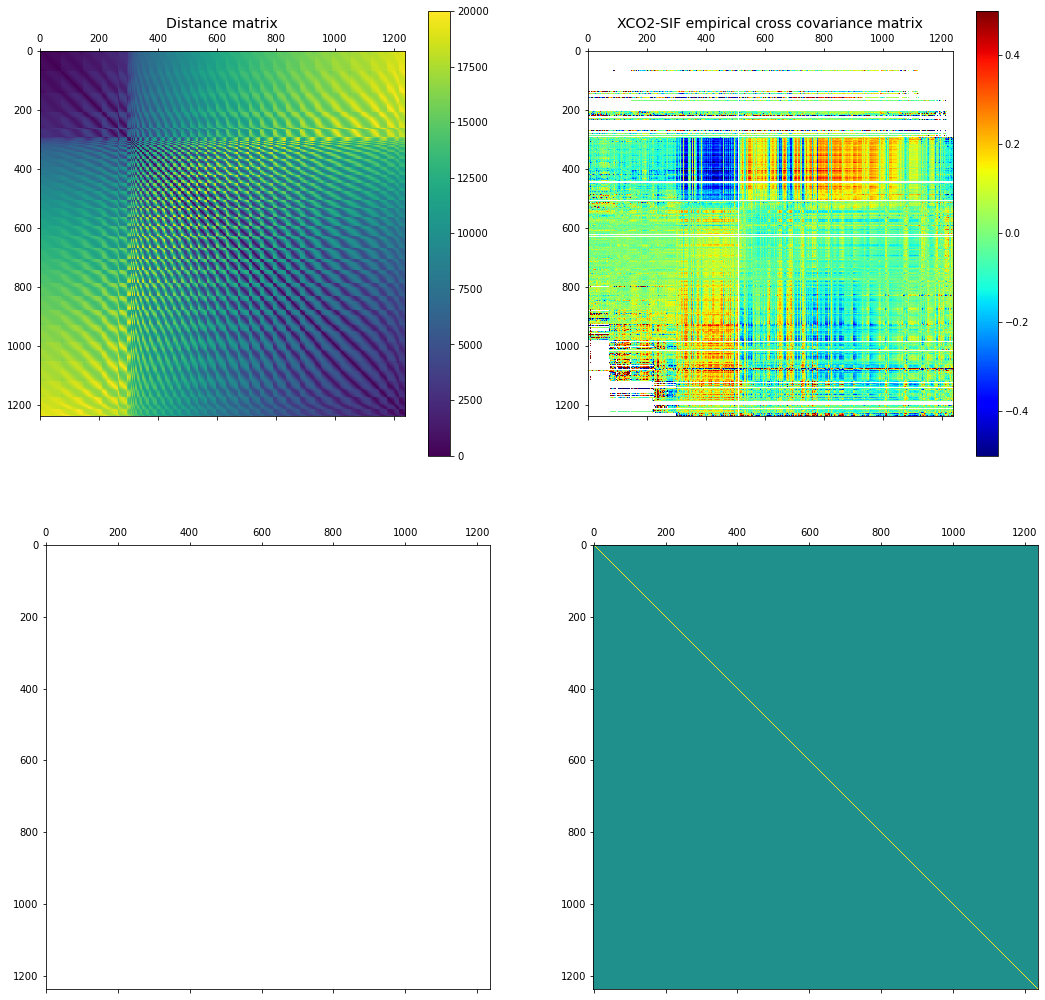

In [44]:
# NOTE: The cross-covariance is not symmetric, but there's no reason it should be...
fig, ax = plt.subplots(2, 2, figsize=(18,18))

ax[0,0].set_title("Distance matrix", size=14);
cax0 = ax[0,0].matshow(dist_mat)
fig.colorbar(cax0, ax=ax[0,0])

ax[0,1].set_title("XCO2-SIF empirical cross covariance matrix", size=14);
cax1 = ax[0,1].matshow(xcov, cmap="jet", vmin=-0.5, vmax=0.5)
fig.colorbar(cax1, ax=ax[0,1])

ax[1,0].matshow(xco2_diag @ xcov, vmin=-0.5, vmax=0.5)

ax[1,1].matshow(sif_diag, vmin=-0.5, vmax=0.5);

# fig, ax = plt.subplots(figsize=(12,8))
# cax = ax.matshow(xcov, cmap="jet", vmin=-0.5, vmax=0.5)
# fig.colorbar(cax)
# ax.set_title("XCO2-SIF empirical cross covariance matrix", size=16);

In [11]:
# NEXT: work on eqn 5.7 (just need to sort out pairs within time lag)
# Actually, consider getting all pairs of points in table, then using a function of binned distance and temporal lag with ops like "where"
# If we look at ALL pairs, we're talking numbers in the billions... may need to use loops for each type of lag (can precompute spatial and temporal distances though)

In [71]:
df[["lat_lon", "time", "sif_res", "xco2_res"]]

,lat_lon,time,sif_res,xco2_res
0,"(-87.5, -177.5)",2014-09-01,NaN,NaN
1,"(-87.5, -177.5)",2014-10-01,NaN,NaN
2,"(-87.5, -177.5)",2014-11-01,-0.354729,NaN
3,"(-87.5, -177.5)",2014-12-01,-2.333229,NaN
4,"(-87.5, -177.5)",2015-01-01,NaN,NaN
...,...,...,...,...
92770,"(82.5, 97.5)",2020-07-01,NaN,NaN
92771,"(82.5, 97.5)",2020-08-01,0.382417,NaN
92772,"(82.5, 97.5)",2020-09-01,NaN,NaN
92773,"(82.5, 97.5)",2020-10-01,NaN,NaN
